# Hierarchical Clustering

## Autoreload

Autoreload allows the notebook to dynamically load code: if we update some helper functions *outside* of the notebook, we do not need to reload the notebook.

In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import numpy as np
import pandas as pd
import os
import sys
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import procyclingstats as pcs
import umap

from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering

# Otherwise nothing will be found
sys.path.append(os.path.abspath(os.path.join('..')))

from utility.cluster_utility import scale_data, hier_search, get_average_per_cluster

/home/yuri/anaconda3/envs/hlt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-29 20:46:55.170950: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Global variables, constants, etc.

In [3]:
sys.path.append('../dataset/')
sys.path.append('../utility/')

# Global variables, constants
IMAGE_DIR = '../images/'
RANDOM_STATE = 42
hyperparametrs = {
    'n_clusters': np.arange(3, 10), # starting from 3 because with 2 clusters we just get outlier detection
    'linkage': ['single', 'complete', 'average', 'ward']
}
RUN_GRID_SEARCH = False

We've spent a lot of effort into engineering new features, understanding them, etc. Whether we've done this well and whether is enough it's a different story.

The point here is that - after the understanding, engineering and transformation - we have some cleaned-up versions of the datasets.

In [4]:
cyclists_df = pd.read_csv('../dataset/cyclists_cleaned.csv')
races_df = pd.read_csv('../dataset/races_cleaned.csv')

Let's reduce the dimensionality of the dataset by dropping useless or non-descriptive columns. The last three columns of `cyclists_df` have been dropped because of their correlation with other columns and the presence of strong outliers

In [5]:
cyclists_df = cyclists_df.select_dtypes(include=[np.number])
cyclists_df = cyclists_df.drop(columns=['birth_year', 'weight', 'height', 'avg_points_per_race', 'stamina_index'])
cyclists_df = cyclists_df.dropna()

In [6]:
races_df = races_df.select_dtypes(include=[np.number])
races_df = races_df.drop(columns=['uci_points', 'quality_adjusted_points', 'position', 'delta', 'cyclist_age', 'age_performance_index', 'profile', 'profile_adjustment', 
                                  'season', 'norm_points', 'normalized_length', 'normalized_quality', 'normalized_steepness', 'time_seconds', 'normalized_time', 'stamina_index'])
races_df = races_df.dropna()

Because of its high resemblance to a categorical variable (check the data understanding notebook for proof), we decided to remove the `points` column to weed out bad clusters. While `steepness` defines a relation between `length` and `climb_total`, we thought that hierarchical clustering could benefit from this feature because it is quite correlated with `profile`, which is categorical, and is a continuous variable with a distribution that has no sensational outliers (thus not impairing the clustering algorithms).

In [7]:
races_df = races_df.drop(columns=['points'])
races_df = races_df.drop_duplicates()

# Cyclists

Let's scale the data

In [8]:
cyc_normalizer, cyc_normalized = scale_data(cyclists_df)

Let's check how the silhouette scores for the selected linkage types and maximum clusters compare

In [9]:
if RUN_GRID_SEARCH: search_results = hier_search(hyperparametrs, cyc_normalized)

Let's check them

In [10]:
if RUN_GRID_SEARCH: search_results

Looks like the best silhouette score is reached by single linkages with 3 clusters. 

Let's try to plot it

In [11]:
single_linkage = AgglomerativeClustering(n_clusters=3, linkage='single')
labels = single_linkage.fit_predict(cyc_normalized)

In [12]:
cyclists_df['cluster'] = labels

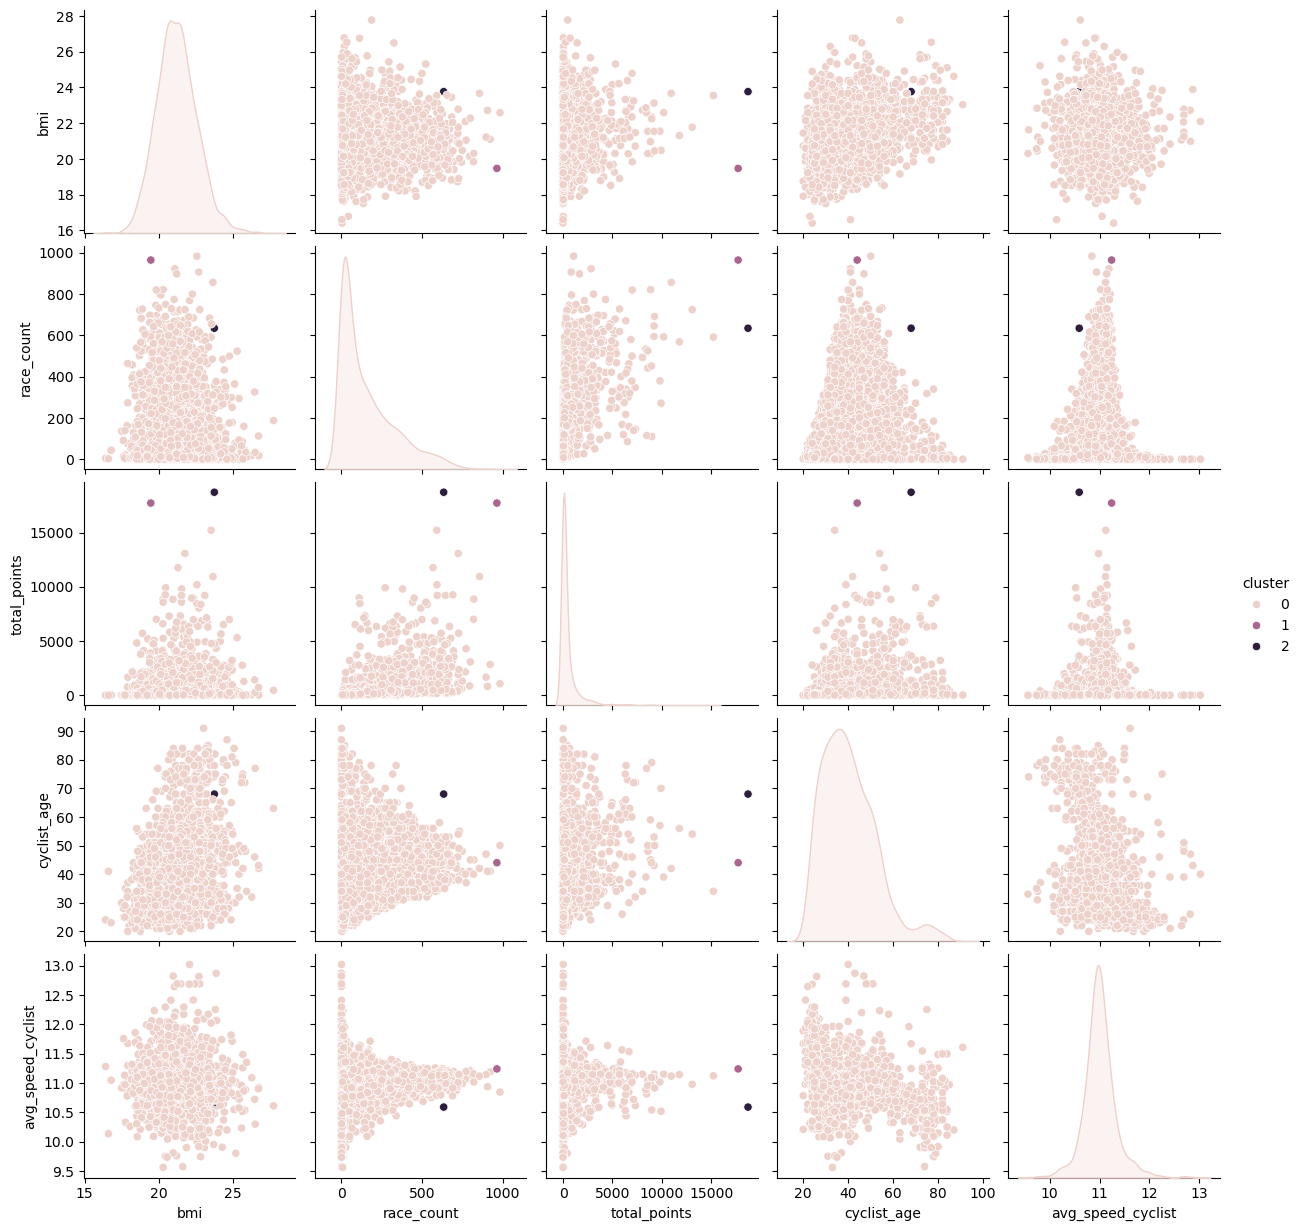

In [13]:
# plot all pairs of values and color by cluster
sns.pairplot(cyclists_df, hue='cluster')
plt.show()

And it just looks like a mediocre result for outlier detection! As expected, MIN suffers a lot from outliers and noise. Let's check how the best average works

In [14]:
average_linkage = AgglomerativeClustering(n_clusters=3, linkage='average')
labels = average_linkage.fit_predict(cyc_normalized)

In [15]:
cyclists_df['cluster'] = labels

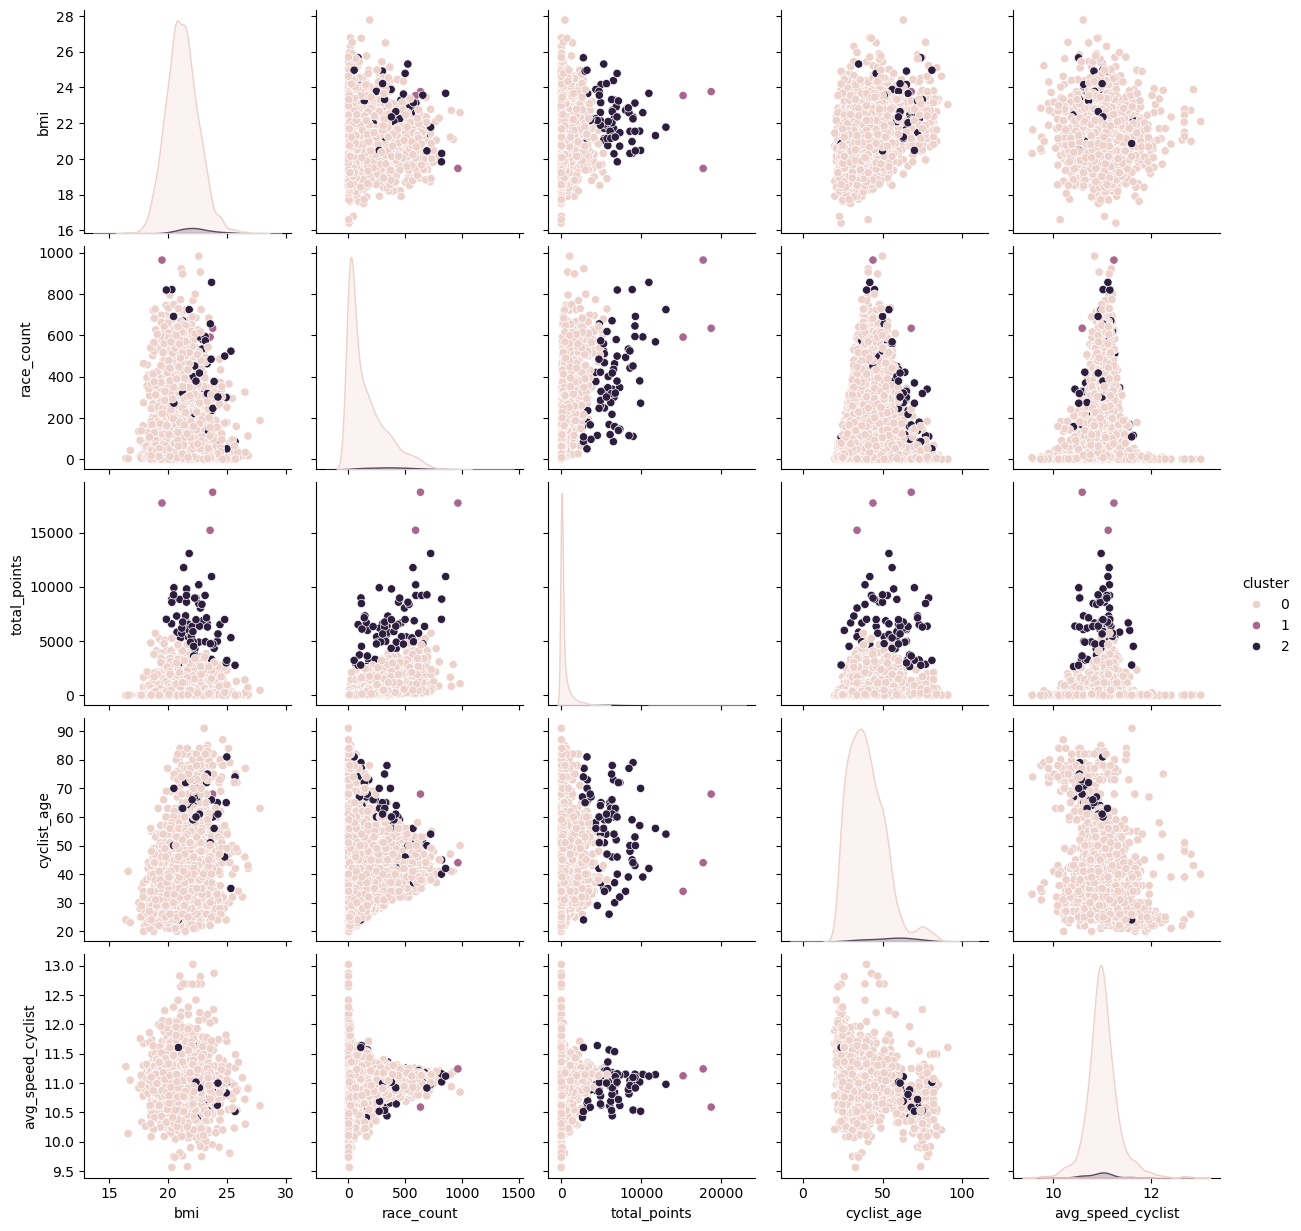

In [16]:
# plot all pairs of values and color by cluster
sns.pairplot(cyclists_df, hue='cluster')
plt.show()

It's still suffering, albeit doing a bit better. The main reason seems to be some cyclists having totalized a great deal of points. Let's check how MAX goes.

In [17]:
# show only the rows of silhouettes where linkage = 'complete'

if RUN_GRID_SEARCH: search_results[search_results['linkage'] == 'complete']

In [18]:
complete_linkage = AgglomerativeClustering(n_clusters=3, linkage='complete')
labels = complete_linkage.fit_predict(cyc_normalized)
cyclists_df['cluster'] = labels

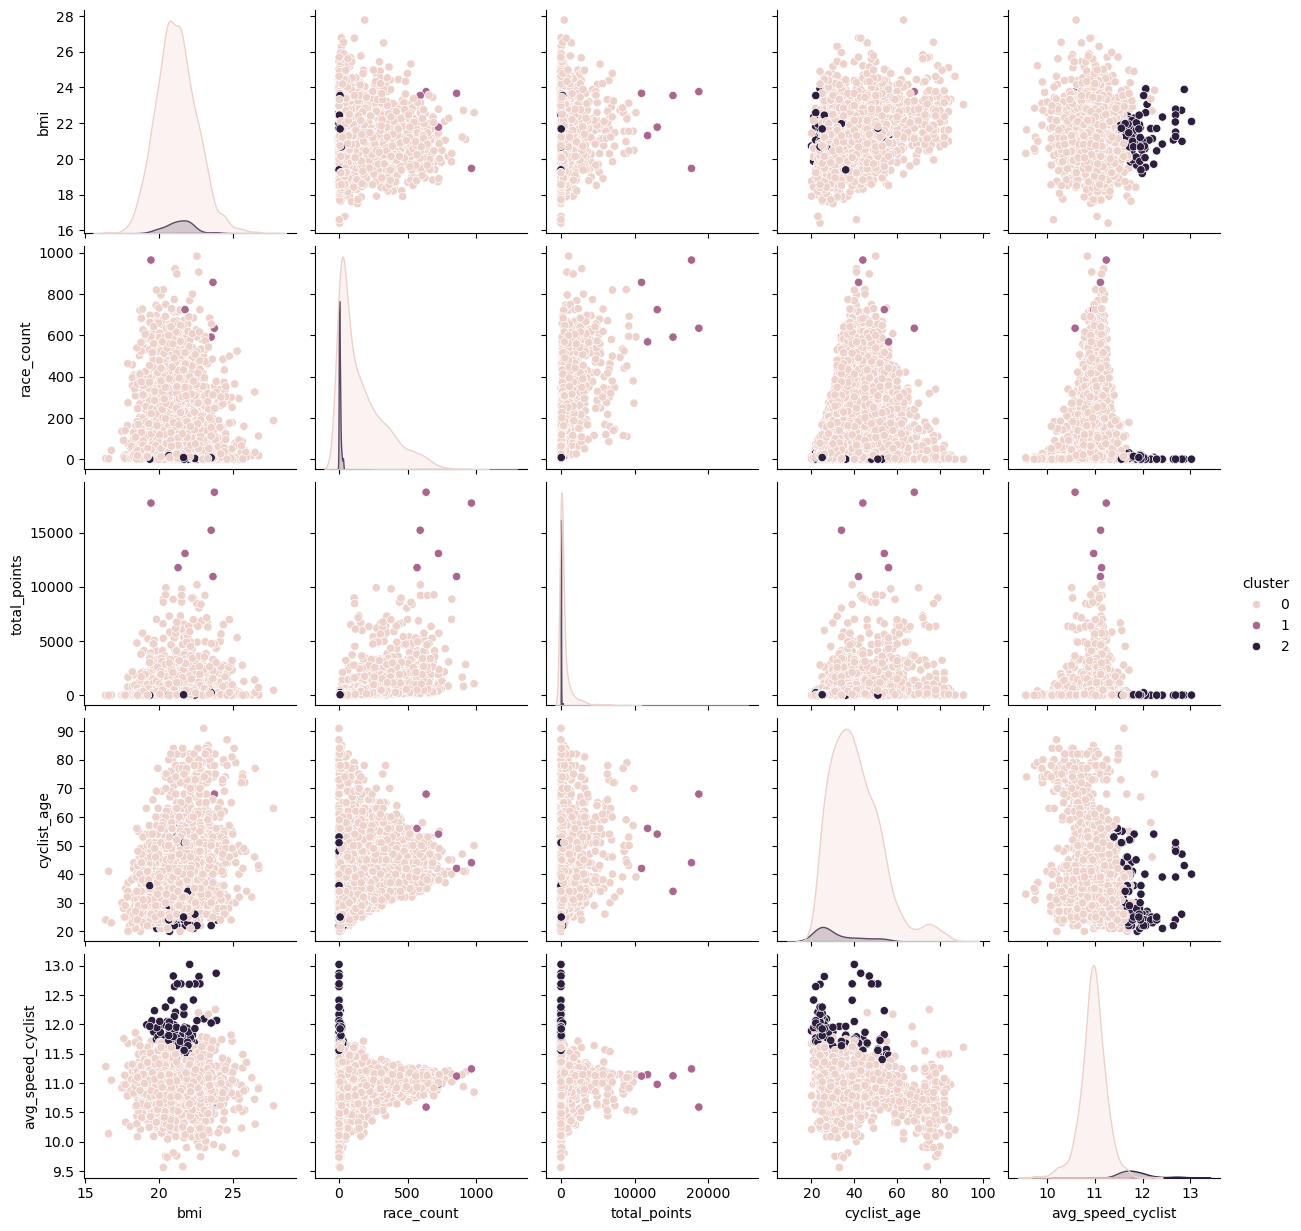

In [19]:
# plot all pairs of values and color by cluster
sns.pairplot(cyclists_df, hue='cluster')
plt.show()

Well, a bit of a more satisfying division.

In [20]:
avg_cycl, _ = get_average_per_cluster(labels, cyclists_df)
avg_cycl

bmi  race_count  total_points  cyclist_age  avg_speed_cyclist  \
cluster                                                                        
0        21.200708  165.881107    537.854458    40.783396          10.965743   
1        22.256619  723.833333  14578.166667    49.666667          11.032568   
2        21.384054    6.475806     18.056452    31.870968          11.866350   

         cluster_size  
cluster                
0                2927  
1                   6  
2                 124

The first cluster represents experienced, older cyclists who participate in a good number of races and perform moderately well. <br>
The second cluster represents a small group of competitive cyclists that perform exceedingly well and have the highest experience. This is basically a set of outliers <br>
The third cluster consists of younger and less experienced cyclists that tend to end up in poorer positions.


Let's check how Ward's Method fared

In [21]:
# show only the rows of silhouettes where linkage = 'complete'

if RUN_GRID_SEARCH: search_results[search_results['linkage'] == 'ward']

In [22]:
ward_linkage = AgglomerativeClustering(n_clusters=5, linkage='ward')
labels = ward_linkage.fit_predict(cyc_normalized)
cyclists_df['cluster'] = labels

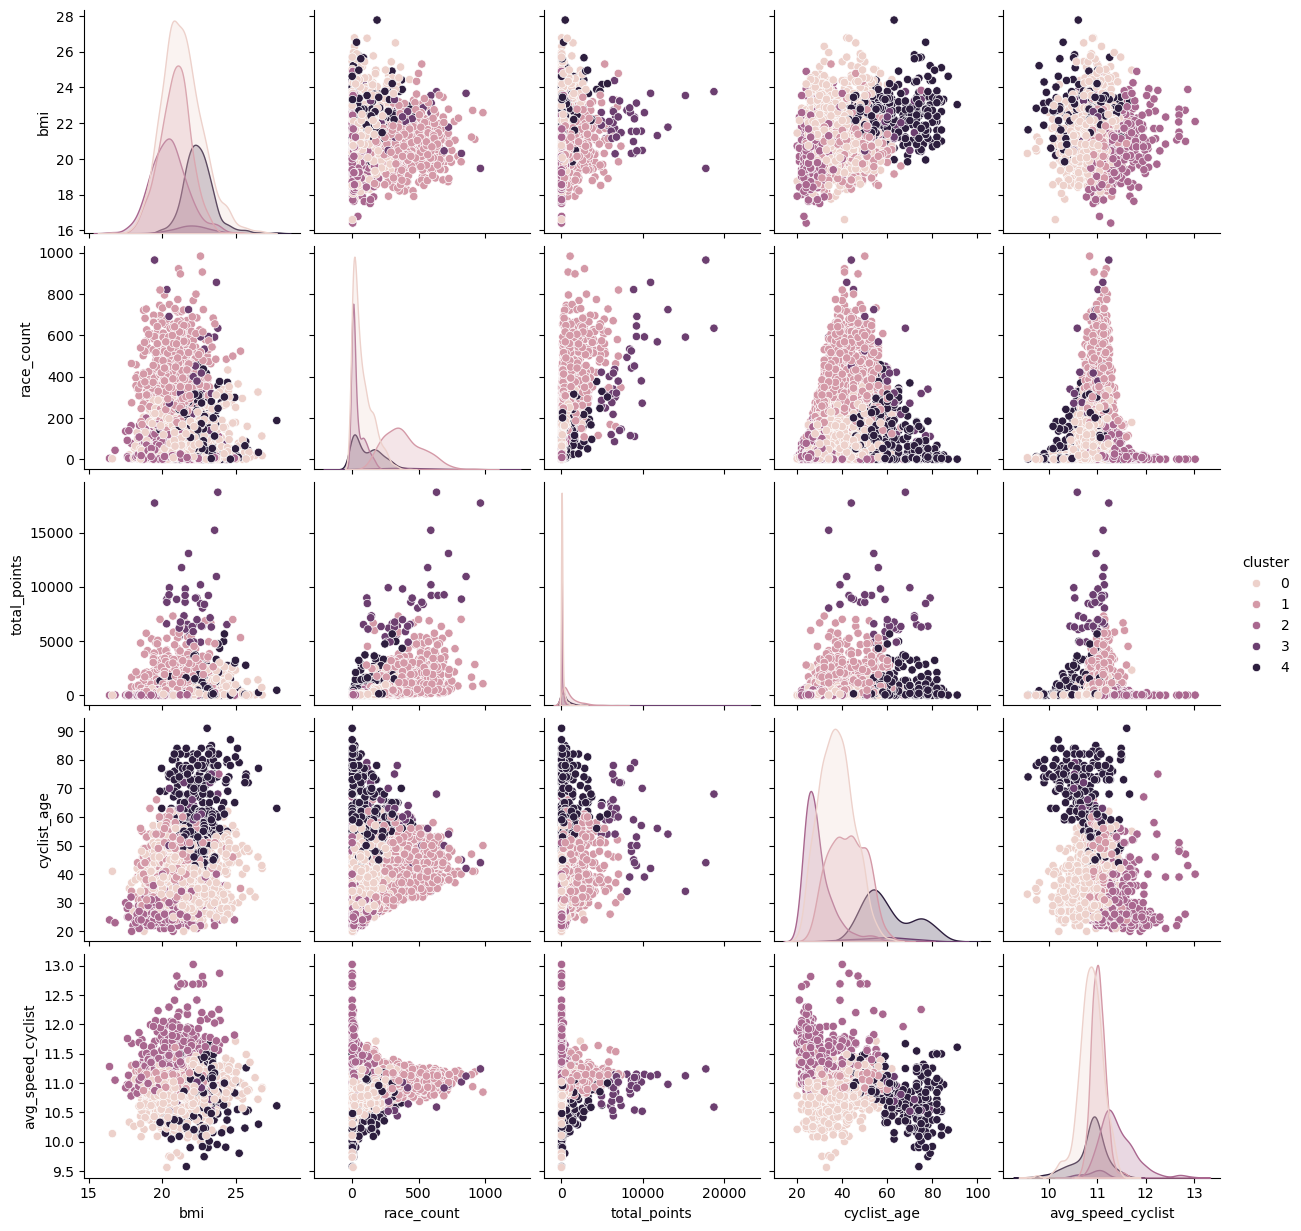

In [23]:
# plot all pairs of values and color by cluster
sns.pairplot(cyclists_df, hue='cluster')
plt.show()

In [24]:
avg_cycl, _ = get_average_per_cluster(labels, cyclists_df)
avg_cycl

bmi  race_count  total_points  cyclist_age  avg_speed_cyclist  \
cluster                                                                        
0        21.339385   77.282774    123.852134    37.377287          10.867593   
1        20.872265  386.095477   1125.810302    42.337940          11.023041   
2        20.458718   39.156604     66.388679    29.535849          11.414483   
3        21.968572  418.166667   8395.095238    57.785714          10.919070   
4        22.446252  115.748011    577.159151    60.482759          10.857969   

         cluster_size  
cluster                
0                1312  
1                 796  
2                 530  
3                  42  
4                 377

Division seem to be mainly focused on the number of races and age. <br>
The first is the largest group of cyclists, on the young-middle age side, who partecipated in quite some races but tend to have mediocre performances. <br>
The second represents more experienced cyclists that accumulated a discrete number of points. Their performance is better, albeit still mediocre, and their average speed is slightly above other clusters <br>
The third consists of the youngest and most lightweight cyclists who perform almost as well as the previous cluster. Albeit inexperienced, they are the fastest cluster. <br>
The fourth seems to represent a group of the best, most experienced cyclists with great performance metrics. <br>
The last cluster represents, probably, historical cyclists that performed exceptionally well. It is interesting to note that their BMI is higher, compared to other groups, and that their race count isn't that high, probably due to not much data being cleanly collected on them


Let's see how this clustering appears in tridimensional space. We'll use UMAP to reduce its dimensionality.

In [25]:
reducer = umap.UMAP(n_neighbors=15, learning_rate=0.1, n_components=3, random_state=RANDOM_STATE)

In [26]:
reduced_data = reducer.fit_transform(cyc_normalized)

/home/yuri/anaconda3/envs/hlt/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [27]:
# Prepare data for Plotly
df = pd.DataFrame({
    'UMAP 1': reduced_data[:, 0],
    'UMAP 2': reduced_data[:, 1],
    'UMAP 3': reduced_data[:, 2],
    'Cluster': ward_linkage.labels_
})

# Create interactive 3D scatter plot
fig = px.scatter_3d(
    df,
    x='UMAP 1',
    y='UMAP 2',
    z='UMAP 3',
    color='Cluster',
    title='UMAP 3D',
    color_continuous_scale='Viridis'
)

fig.show()

Looks like the clustering in three dimensions keeps some sort of homogenity, albeit the clusters appear to be all but globular (which is expected from hierarchical clustering).

# Races

Let's scale the data

In [28]:
rac_normalizer , rac_normalized = scale_data(races_df)

Let's check how the silhouette scores for the selected linkage types and maximum clusters compare

In [29]:
if RUN_GRID_SEARCH: 
    search_results = hier_search(hyperparametrs, rac_normalized, samples = 80)
    search_results

Let's see how the first three results fared out

## First Linkage

In [30]:
first_linkage_races = AgglomerativeClustering(n_clusters=3, linkage='average')
second_linkage_races = AgglomerativeClustering(n_clusters=4, linkage='average')
third_linkage_races = AgglomerativeClustering(n_clusters=3, linkage='ward')

In [31]:
labels = first_linkage_races.fit_predict(rac_normalized)
races_df['cluster'] = labels

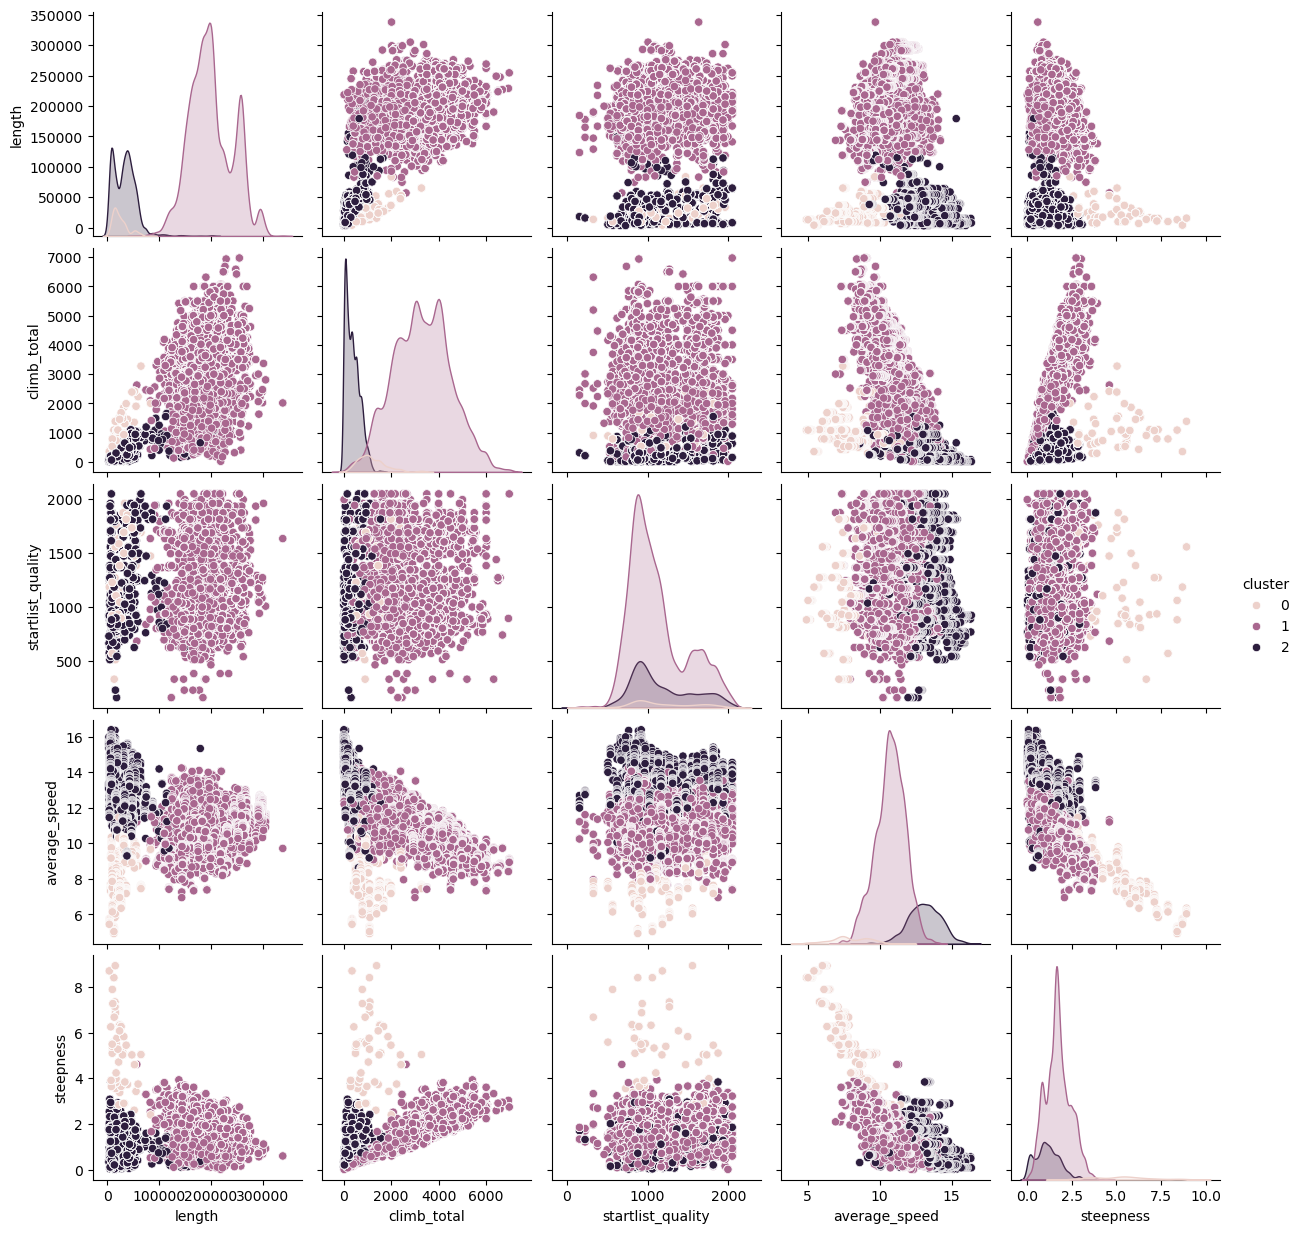

In [32]:
# plot all pairs of values and color by cluster
sns.pairplot(races_df, hue='cluster')
plt.show()

In [33]:
avg_cycl, _ = get_average_per_cluster(labels, races_df)
avg_cycl

length  climb_total  startlist_quality  average_speed  \
cluster                                                                 
0         24512.696629  1180.545746        1194.309791       7.908712   
1        199452.299637  3293.457395        1114.734515      10.731507   
2         33038.856209   364.616459        1177.387998      13.102237   

         steepness  cluster_size  
cluster                           
0         5.297993           623  
1         1.716081         14611  
2         1.129736          3366

The first cluster denotes shorter, steeper races that proved to be more challenging, considering the very slow speed achieved albeit being the cluster with the highest startlist_quality. The cluster is relatively small, hinting that races that are this difficult only compose a small subset of all the races. <br>
The second cluster, which is the biggest, with an average length of 200km, denotes all the longer races, which are more endurance-focused. An higher average speed wrt to the first cluster is expected because the steepness dramatically falls, indicating less aggressive albeit longer climbs, while it is also expected to be smaller than the next cluster because of its length. Here, the startlist quality is the smallest, indicating with the fact that the cluster size is so high, that races are more common and faced by more people with different skill levels. <br>
The third cluster indicates races that are on almost flat terrain, with the highest average speeds. These sprint-races present a bit of a higher startlist quality that indicates they are dwelled by slightly more professional individuals, instead of being the 3000 participants marathons.

Since it's the best one in terms of silhouette and looks reasonably well divided, let's visualize it with UMAP

In [34]:
reducer_races = umap.UMAP(n_neighbors=15, learning_rate=0.1, n_components=3, random_state=RANDOM_STATE)

In [35]:
reduced_data = reducer_races.fit_transform(rac_normalized)

/home/yuri/anaconda3/envs/hlt/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [36]:
# Prepare data for Plotly
df = pd.DataFrame({
    'UMAP 1': reduced_data[:, 0],
    'UMAP 2': reduced_data[:, 1],
    'UMAP 3': reduced_data[:, 2],
    'Cluster': labels
})

# Create interactive 3D scatter plot
fig = px.scatter_3d(
    df.iloc[:5000],
    x='UMAP 1',
    y='UMAP 2',
    z='UMAP 3',
    color='Cluster',
    title='UMAP 3D',
    color_continuous_scale='Viridis'
)

fig.show()

We had to reduce the number of plotted points to keep my laptop from imploding into a singularity.
It looks like there is a central bulk (the long races) from which the first and the second cluster "escape from", to characterize themselves in different ways. Homogeneity looks all but kept, mainly because of the giant differences in size of the clusters and the sample of data to represent.

## Second Linkage

In [37]:
labels = second_linkage_races.fit_predict(rac_normalized)
races_df['cluster'] = labels

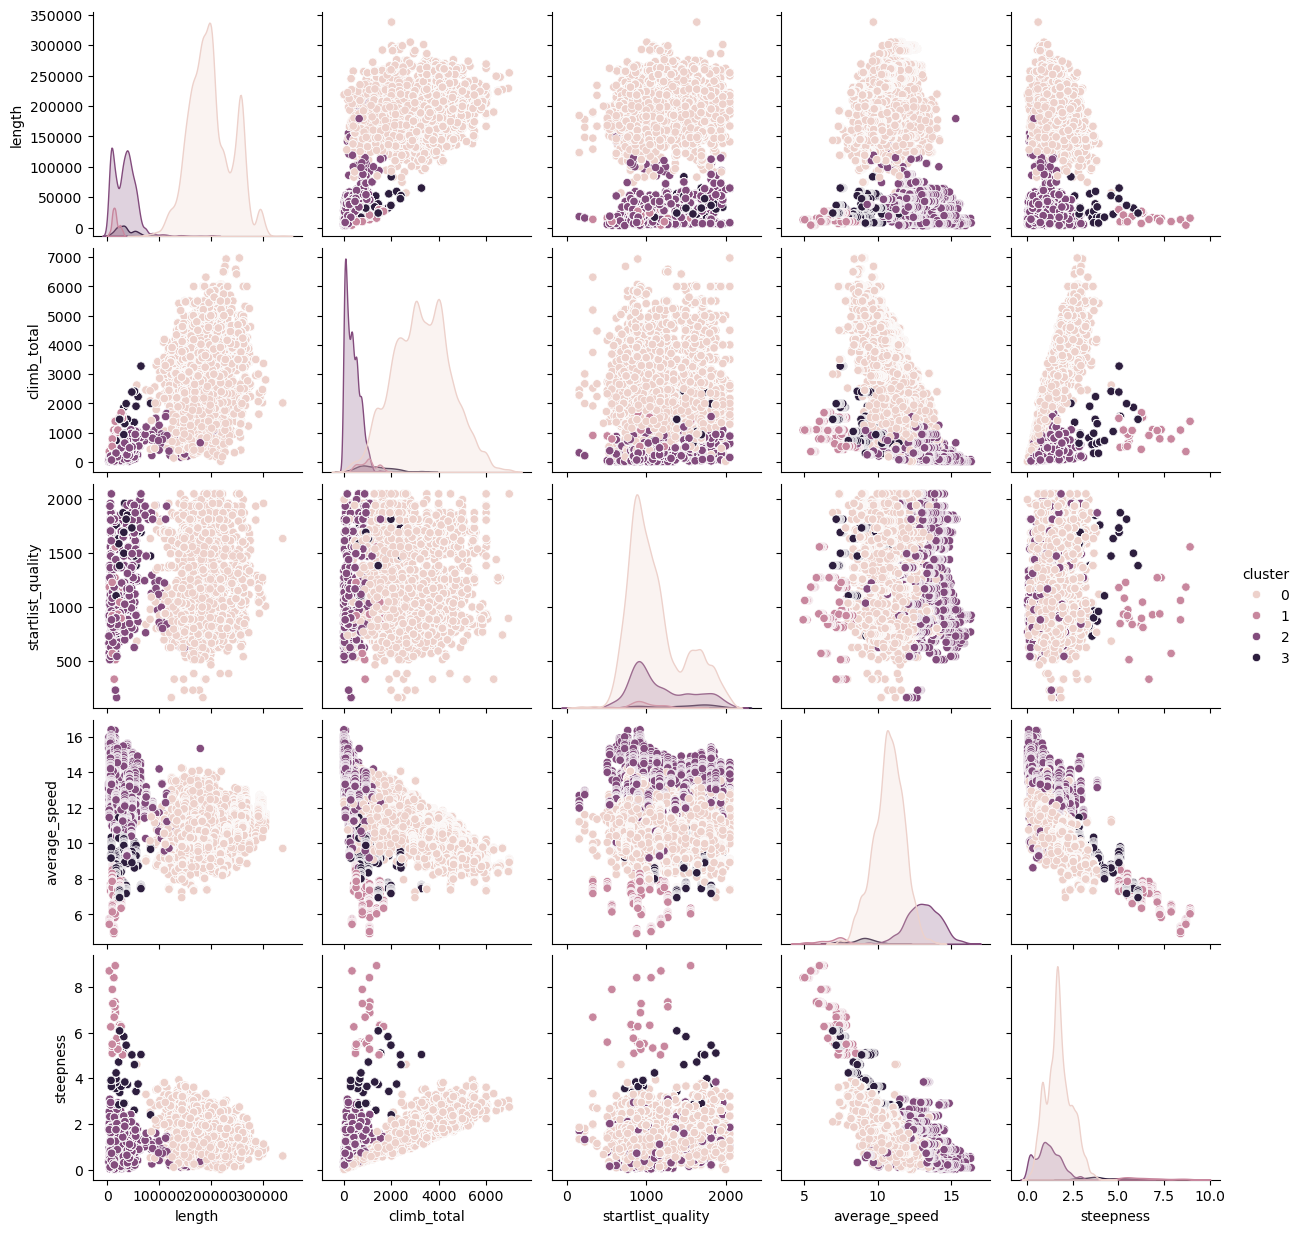

In [38]:
# plot all pairs of values and color by cluster
sns.pairplot(races_df, hue='cluster')
plt.show()

In [39]:
avg_cycl, _ = get_average_per_cluster(labels, races_df)
avg_cycl

length  climb_total  startlist_quality  average_speed  \
cluster                                                                 
0        199452.299637  3293.457395        1114.734515      10.731507   
1         15721.987179   999.336538         960.858974       6.931128   
2         33038.856209   364.616459        1177.387998      13.102237   
3         33331.672026  1362.337621        1428.511254       8.889440   

         steepness  cluster_size  
cluster                           
0         1.716081         14611  
1         6.497140           312  
2         1.129736          3366  
3         4.094990           311

Same method as before, but now with an additional cluster!
We can see that the split has been made on the last cluster, giving off a shorter, steeper and slower cluster as cluster 1. The mean startlist quality is low, meaning that these kind of races were boosted in rating by the ones coming from cluster 3, which is composed of (probably, considering the startlist quality) more prestigious races

## Third Linkage

In [40]:
labels = third_linkage_races.fit_predict(rac_normalized)
races_df['cluster'] = labels

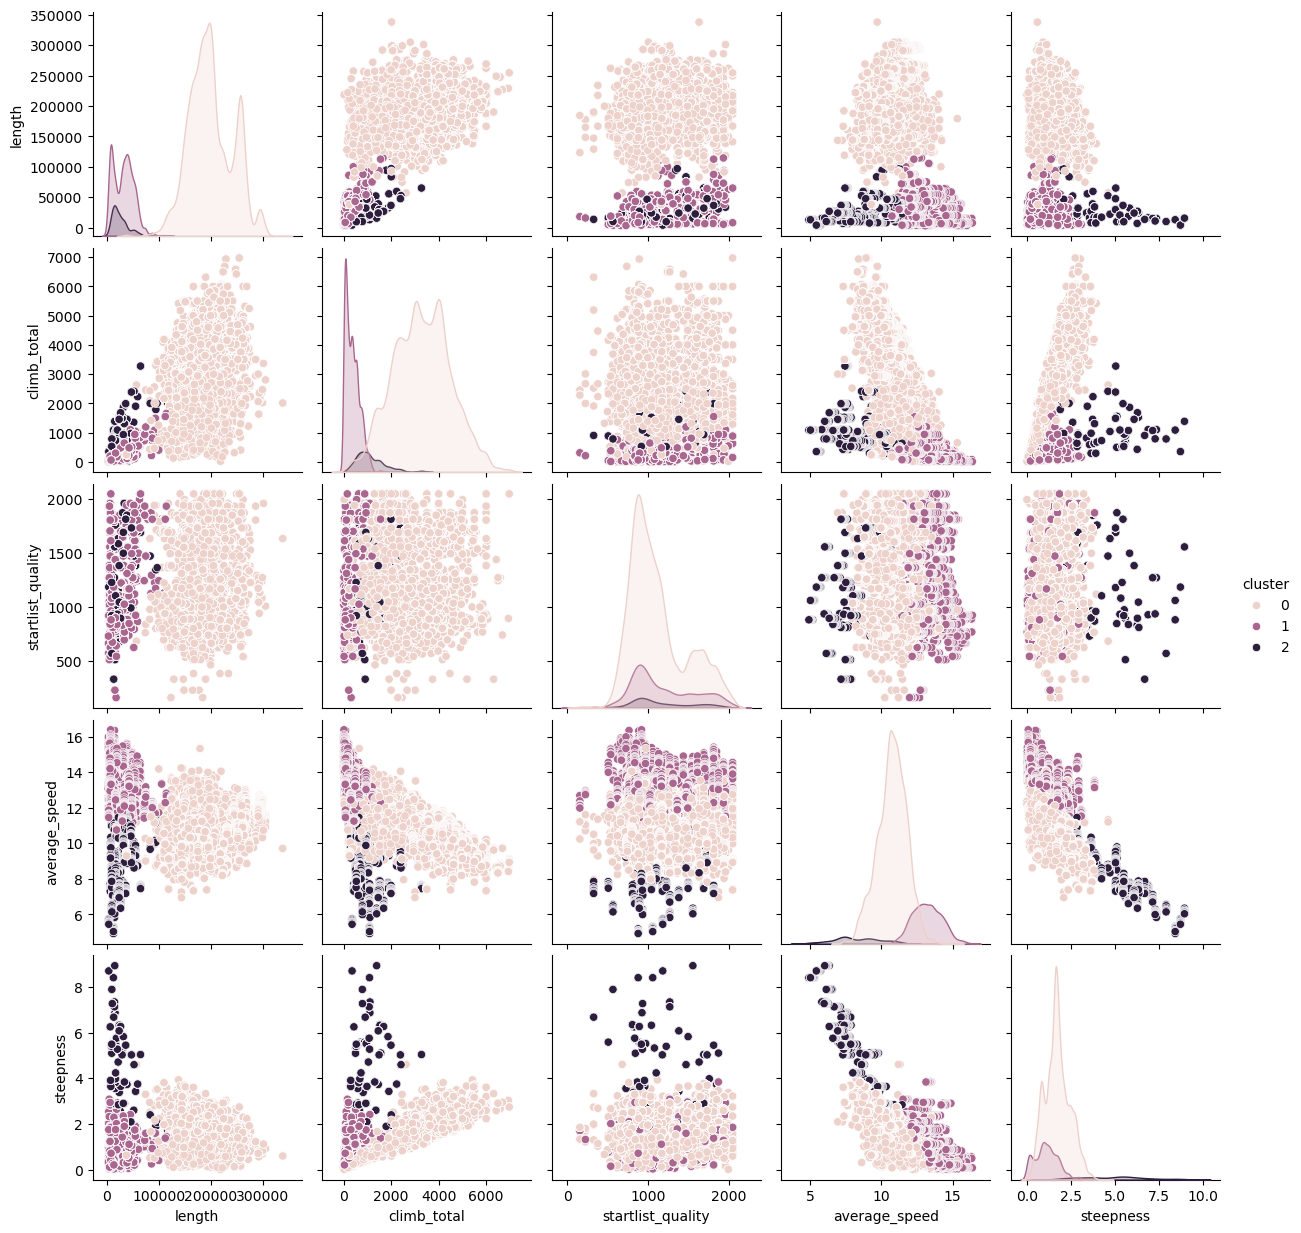

In [41]:
# plot all pairs of values and color by cluster
sns.pairplot(races_df, hue='cluster')
plt.show()

In [42]:
avg_cycl, _ = get_average_per_cluster(labels, races_df)
avg_cycl

length  climb_total  startlist_quality  average_speed  \
cluster                                                                 
0        199183.254846  3285.174311        1114.251502      10.730076   
1         32146.900929   354.863467        1186.253251      13.205316   
2         25640.961003  1118.247911        1165.623955       8.296739   

         steepness  cluster_size  
cluster                           
0         1.712383         14652  
1         1.105552          3230  
2         4.897248           718

The first blob-cluster stays pretty much the same, with just 41 more datapoints. <br>
The second cluster is, again, very similar to the average method. <br>
The third cluster encapsulates the remaining records plus some of the races lost by the other clusters. <br>
What we can see is that Ward's method gives off clusters with a bit less skewed values of steepness. Nothing that much more interesting